In [42]:
import NLP_Preprocessor as nlp
import re 

import wikipediaapi

import glob
import pickle

import time

## Download dataset methods

In [2]:
stopLinks = ["BBC"]

In [3]:
wiki = wikipediaapi.Wikipedia('en')

def getLinks(title, layer, maxLayer,allTitles):
    if layer <= maxLayer: # if its not the max layer
        global stopLinks
        if title not in allTitles and title not in stopLinks: # if it has not already been seen
            allTitles[title] = 0 # add to dict of seen titles
            if layer != maxLayer:
                wikiPage = wiki.page(title) #get page
                if len(wikiPage.links) > 500:
                    print(len(wikiPage.links),"\t",title)
                for link in wikiPage.links: # for each link
                    allTitles = getLinks(link,layer + 1,maxLayer,allTitles) # recurse
    return allTitles
    
def getWikiTitles(title,saveLocation,allTitles, maxLayer):
    
    #getLinks
    allTitles = getLinks(title, 0, maxLayer, allTitles)
    return allTitles


def downloadWikiData(allTitles,pagesPerFile = 100):
    rawText = ""
    for i,title in enumerate(allTitles.keys()):
        #get the wikipage text
        wikiPage = wiki.page(title)
        rawText += wikiPage.text.replace("\n","") + "\n"
        
        #save the file
        if i % pagesPerFile == 0:
            print(i,len(rawText))
            file = open("../Data/WikiData/" + str(i) + ".txt","w",encoding="utf-8")#saveLocation+title.replace(" ","_")+".txt", 'w')
            file.write(rawText.replace("\n"," "))
            file.close()
            rawText = ""
            
    print("Final save")
    file = open("../Data/WikiData/final.txt","w",encoding="utf-8")#saveLocation+title.replace(" ","_")+".txt", 'w')
    file.write(rawText.replace("\n"," "))
    file.close()

## Downloading dataset

In [38]:
seedPages = ["Neuroscience".title(),"Action potential".title(),"Brain damage".title(),"Brain imaging".title(),"Brain science".title(),"Brain".title()]

maxLayer = 0
allTitles = dict()
for page in seedPages:
    print(page)
    allTitles = getWikiTitles(page,"../Data/WikiData/",allTitles,maxLayer)

print(len(allTitles))

downloadWikiData(allTitles)


Neuroscience
Action Potential
Brain Damage
Brain Imaging
Brain Science
Brain
6
0 21859
Final save


# Word vector methods

In [30]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    corpus_words = [y for x in corpus for y in x]
    corpus_words = sorted(set(corpus_words))
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    
    # ------------------
    # Write your implementation here.
    count = 0
    for word in words:
        word2Ind[word] = count
        count += 1
        
    M = np.zeros((num_words,num_words))
    
    for sentence in corpus:
        for x in range(len(sentence)):
            word = sentence[x]
            surroundings = sentence[max(0,x-window_size):min(len(sentence),x+window_size+1)]
            #print(surroundings,max(0,x-window_size),min(x+window_size+1,flatCorpusLen))
            
            for contextWord in surroundings:
                M[word2Ind[word]][word2Ind[contextWord]] +=1

    for word in word2Ind:
        M[word2Ind[word]][word2Ind[word]] = 0
    # ------------------

    return M, word2Ind

def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    #svd =  TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    svd = PCA(n_components=k, random_state=42)
    M_reduced = svd.fit_transform(M)

    # ------------------

    print("Done.")
    return M_reduced

def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.


    for i,word in enumerate(words):
        x = M_reduced[word2Ind[word]][0]
        y = M_reduced[word2Ind[word]][1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)
    plt.show()

## Read in dataset

In [45]:
def getWordSentencesFromDocument(filename):
    file = open(filename,"r",encoding="utf-8")#saveLocation+title.replace(" ","_")+".txt", 'w')
    rawText = file.read()
    file.close()
    rawText = rawText.lower()
    #loading and cleansing data
    START_TOKEN = 'START '
    END_TOKEN = ' END'

    #rHTMLtext = re.sub("\\[[0-9]+]" , " ", rawText)
    rHTMLtext = re.sub("—" , "-", rawText)
    # replacing numbers
    text = nlp.numberReplacer(rHTMLtext,replaceString=" NUMBERS ")
    #splitting out sentences
    sentences = nlp.sentenceSplit(text)
    #adding start and end token
    sentences = [START_TOKEN + s + END_TOKEN for s in sentences]
    #removing symbols
    sentences = [nlp.symbolReplacer(s,extraChars="-",replaceString=" ") for s in sentences]
    #splitting out words
    wordSentences = [nlp.wordSplit(sentence) for sentence in sentences]
    #removing stop words
    wordSentences = [nlp.removeStopWords(sentence) for sentence in wordSentences]
    #lemmatizing words
    wordSentences = [nlp.lemmatizeWords(sent) for sent in wordSentences]
    return wordSentences


files = glob.glob("../Data/WikiData/*")
for file in files:
    t0 = time.time()
    print("Starting:",file)
    wordSentences = getWordSentencesFromDocument(file)
    
    with open("../Data/WikiDataProcessed/"+file.split("\\")[-1].split(".")[0]+".pkl", 'wb') as f:
        pickle.dump(wordSentences, f)
    
    t1 = time.time()
    total = t1-t0
    print("Finished:", total)
print("done")


Starting: ../Data/WikiData\0.txt
Finished: 1.600327491760254
Starting: ../Data/WikiData\100.txt
Finished: 107.71434783935547
Starting: ../Data/WikiData\1000.txt
Finished: 131.63911604881287
Starting: ../Data/WikiData\1100.txt
Finished: 118.83508443832397
Starting: ../Data/WikiData\1200.txt
Finished: 164.77854537963867
Starting: ../Data/WikiData\1300.txt
Finished: 41.35242438316345
Starting: ../Data/WikiData\1400.txt
Finished: 125.95520782470703
Starting: ../Data/WikiData\1500.txt
Finished: 94.99117159843445
Starting: ../Data/WikiData\1600.txt
Finished: 138.43317699432373
Starting: ../Data/WikiData\1700.txt
Finished: 45.038585901260376
Starting: ../Data/WikiData\1800.txt
Finished: 112.24390196800232
Starting: ../Data/WikiData\1900.txt
Finished: 114.92317056655884
Starting: ../Data/WikiData\200.txt
Finished: 133.84120345115662
Starting: ../Data/WikiData\2000.txt
Finished: 119.8510103225708
Starting: ../Data/WikiData\2100.txt
Finished: 116.6995358467102
Starting: ../Data/WikiData\2200.txt

Running Truncated SVD over 943 words...
Done.


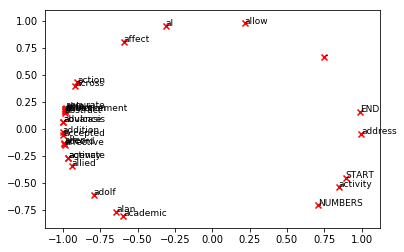

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA




#creating vectors
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(wordSentences)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
words = list(word2Ind_co_occurrence.keys())[0:30]
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)